In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Take a look at some example images from CelebA

In [3]:
base_path = Path('/Users/sjosund/Programming/data/celeba/')
img_base_path = base_path / 'img_align_celeba'
paths = img_base_path.glob('*.jpg')

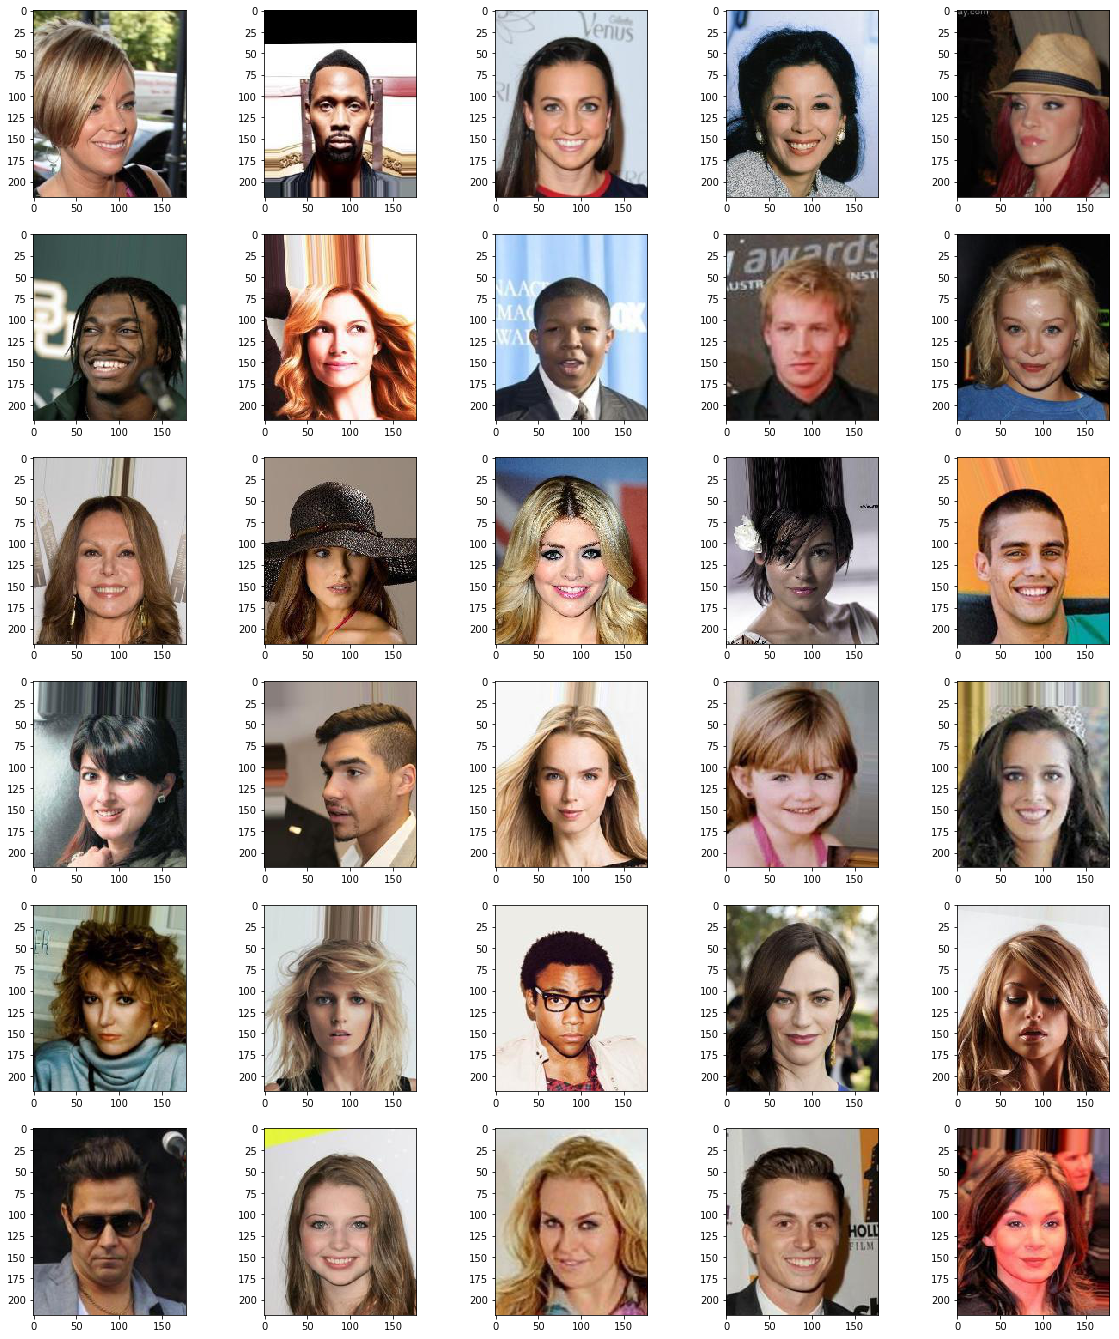

In [4]:
n_imgs = 30

n_cols = 5
n_rows = np.ceil(n_imgs / n_cols).astype(int)

f, axs = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

for i in range(n_imgs):
    ax = axs[i // n_cols, i % n_cols]
    img = plt.imread(next(paths))
    ax.imshow(img)
    

## Look at the annotations

Note that the file contains several whitespaces, so we use `delim_whitespace` to read the file

In [5]:
annotations_path = base_path / 'Anno/list_attr_celeba.txt'
annotations = pd.read_csv(
    annotations_path,
    delim_whitespace=True,
    skiprows=1,
)
annotations[annotations == -1] = 0
annotations.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


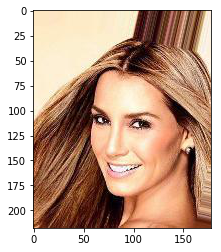

In [6]:
plt.imshow(plt.imread(img_base_path / annotations.index[0]))

In [7]:
used_attributes = ['Young', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male']

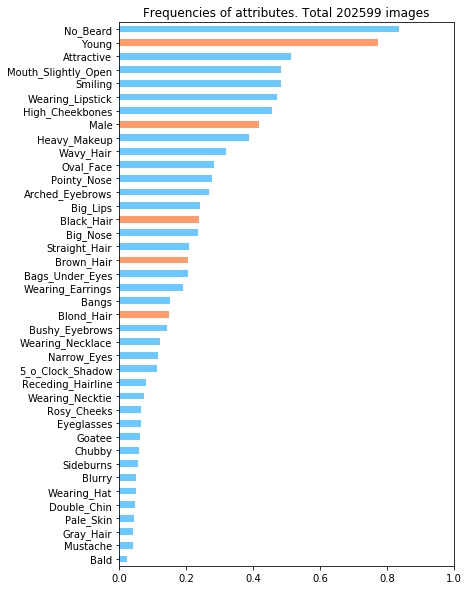

In [8]:
f, ax = plt.subplots(1, 1, figsize=(6, 10))
frequencies = annotations.sum(axis=0).sort_values() / len(annotations)

colors = ['#ff9c6b' if attr in used_attributes else '#6bc9ff' for attr in frequencies.index]

frequencies.plot(kind='barh', color=colors)
ax.set_title('Frequencies of attributes. Total {} images'.format(len(annotations)))
ax.set_xlim([0, 1]);

We see that old is the ones that are not young, and that females are the ones not male.

In [9]:
annotations['path'] = annotations.index.map(lambda p: str(img_base_path / p))

## Build a data loader

In [10]:
# https://www.tensorflow.org/performance/datasets_performance
#prefetch
#N_parallel_calls for map
#map_and_batch instead of map then batch
# Repeat -> Shuffle vs Shuffle -> repeat
# Use tf.contrib.data.shuffle_and_repeat
import tensorflow as tf
sess = tf.InteractiveSession()

In [11]:
used_attributes = ['Male']  # TODO use more attributes

In [12]:
labels = tf.constant(annotations[used_attributes].values, dtype=tf.int8)
paths = tf.constant(annotations['path'].values, dtype=tf.string)

In [13]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 16

In [14]:
def parse_example(labels, path):
    img = tf.read_file(path)
    img = tf.image.decode_jpeg(contents=img, channels=3)
    # TODO Do crop 
    img = tf.image.crop_to_bounding_box(
        image=img,
        offset_height=20,
        offset_width=0,
        target_height=178,
        target_width=178
    )
#     img = tf.image.decode_and_crop_jpeg(contents=img, crop_window=crop_window, )
    img = tf.image.resize_images(img, size=tf.constant(IMG_SIZE, dtype=tf.int32))
    
    return labels, img

In [15]:
def dataset(paths, labels):
    labels_ds = tf.data.Dataset.from_tensor_slices(labels)
    paths_ds = tf.data.Dataset.from_tensor_slices(paths)
    ds = tf.data.Dataset.zip((labels_ds, paths_ds))
    ds = ds.apply(tf.contrib.data.shuffle_and_repeat(buffer_size=128))
    ds = ds.apply(tf.contrib.data.map_and_batch(
        parse_example,
        batch_size=BATCH_SIZE,
        num_parallel_batches=4
    ))
    ds = ds.prefetch(buffer_size=16)
    
    it = ds.make_one_shot_iterator()
    next_source_label, next_image = it.get_next()
    next_source_label = tf.cast(next_source_label, tf.float32)
    
    bernoulli = tf.distributions.Bernoulli(probs=0.5, dtype=tf.float32)
    next_target_label = bernoulli.sample(sample_shape=tf.shape(next_source_label), )
    
    return next_image, next_source_label, next_target_label

In [16]:
next_image, next_source_label, next_target_label = dataset(paths, labels)
X = sess.run([next_image, next_source_label, next_target_label])

### Inspect the dataset

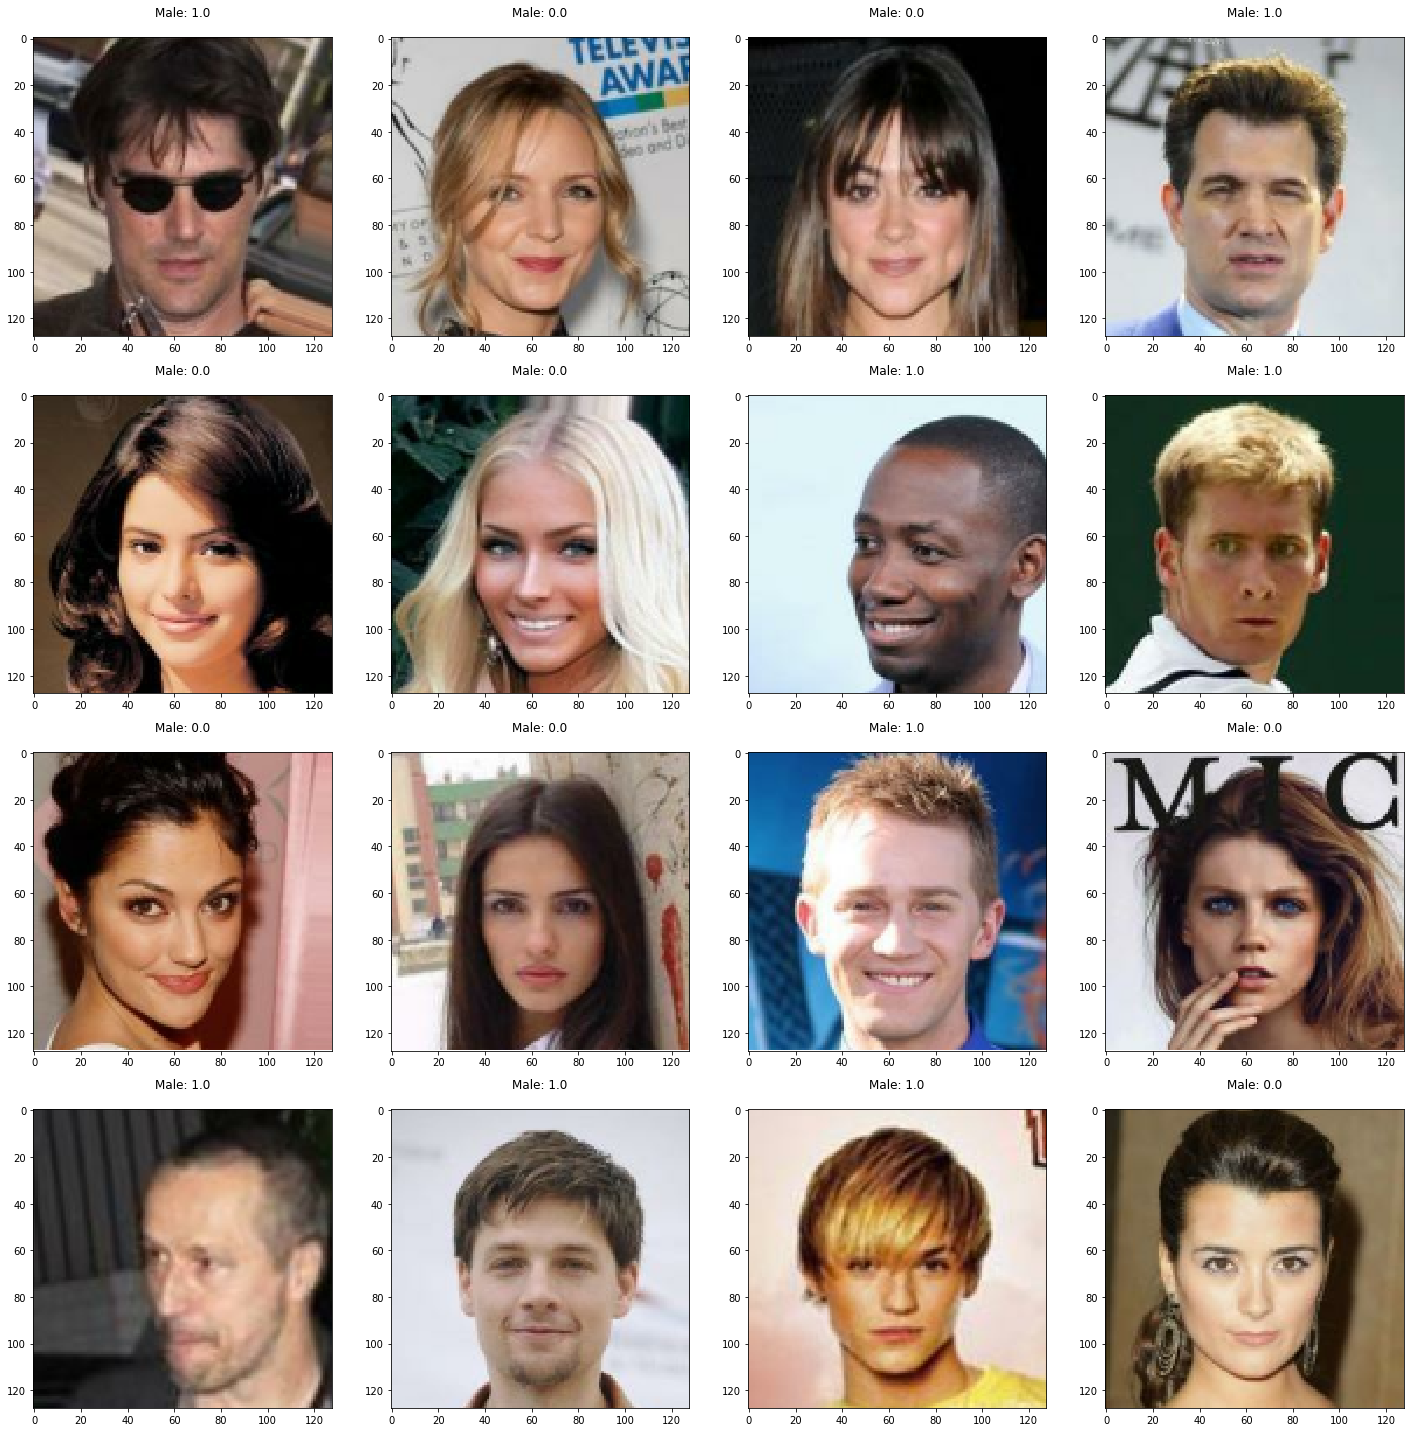

In [17]:
imgs = X[0]

n_cols = 4
n_rows = np.ceil(len(imgs) / n_cols).astype(int)
f, axs = plt.subplots(n_rows, n_cols, figsize=(20, 20))

for i in range(len(imgs)):
    ax = axs[i // n_cols, i % n_cols]
    ax.imshow(X[0][i].astype(int))
    attrs = {k: v for (k, v) in zip(used_attributes, X[1][i])}
    ax.set_title(''.join(['{}: {}\n'.format(k, v) for (k, v) in attrs.items()]))
plt.tight_layout()

## Build the models

### Generator

In [18]:
from tensorflow import keras
from tensorflow.python.keras.layers import (
    ZeroPadding2D,
    Conv2D,
    Conv2DTranspose,
    Activation,
    Conv2DTranspose,
    LeakyReLU,
)

def conv_block(x, filters, kernel_size, stride, padding):
    x = ZeroPadding2D(padding=padding)(x)
    x = Conv2D(
        filters=filters,
        kernel_size=kernel_size,
        strides=stride
    )(x)
    x = tf.contrib.layers.instance_norm(x)
    x = Activation('relu')(x)
    return x

def residual_block(x):
    return conv_block(x, 256, 3, 1, 1)

def deconv_block(x, filters):
    x = Conv2DTranspose(
        filters=filters,
        kernel_size=4,
        strides=2,
        padding='same'
    )(x)
#     x = ZeroPadding2D(padding=1)(x)
    x = tf.contrib.layers.instance_norm(x)
    x = Activation('relu')(x)
    
    return x

def generator(x):
    with tf.variable_scope('generator', reuse=tf.AUTO_REUSE):
        x = conv_block(x, 64, 7, 1, 3)
        x = conv_block(x, 128, 4, 2, 1)
        x = conv_block(x, 256, 4, 2, 1)

        x = residual_block(x)
        x = residual_block(x)
        x = residual_block(x)
        x = residual_block(x)
        x = residual_block(x)
        x = residual_block(x)

        x = deconv_block(x, 128)
        x = deconv_block(x, 64)

        x = ZeroPadding2D(padding=3)(x)
        x = Conv2D(
            filters=3,
            kernel_size=7,
            strides=1,
            activation='tanh'
        )(x)

        return x

### Discriminator

In [19]:
def discriminator_block(x, filters):
    x = ZeroPadding2D(padding=1)(x)
    x = Conv2D(
        filters=filters,
        kernel_size=4,
        strides=2,
    )(x)
    x = LeakyReLU()(x)
    
    return x

def discriminator(x):
    with tf.variable_scope('discriminator', reuse=tf.AUTO_REUSE):
        x = discriminator_block(x, 64)
        x = discriminator_block(x, 128)
        x = discriminator_block(x, 256)
        x = discriminator_block(x, 512)
        x = discriminator_block(x, 1024)
        x = discriminator_block(x, 2048)

        output_cls = Conv2D(filters=1, kernel_size=2)(x)
    #     x = ZeroPadding2D(padding=1)(x)
        output_src = Conv2D(filters=1, kernel_size=2)(x)

        return output_src, output_cls

## Setup loss functions

TODO: They use a gradient penalty, we start by only using the Wasserstein loss

In [20]:
def tf_repeat_to_img(tensor, repeats):
    """
    Args:

    input: A Tensor. 1-D or higher.
    repeats: A list. Number of repeat for each dimension, length must be the same as the number of dimensions in input

    Returns:
    
    A Tensor. Has the same type as input. Has the shape of tensor.shape * repeats
    """
    with tf.variable_scope("repeat"):
        expanded_tensor = tf.expand_dims(tensor, -1)
        multiples = [1] + repeats
        tiled_tensor = tf.tile(expanded_tensor, multiples=multiples)
        repeated_tensor = tf.reshape(tiled_tensor, [tf.shape(tensor)[0]] + repeats + [1])
        repeated_tensor = tf.cast(repeated_tensor, tf.float32)
    return repeated_tensor
#     return tiled_tensor

In [21]:
labels_as_image = tf_repeat_to_img(
    next_target_label,
    next_image.shape.as_list()[1:-1]
)
next_image_with_label = tf.concat(
    [next_image, labels_as_image],
    axis=-1
)

G = generator(next_image_with_label)
D_g, D_g_class = discriminator(G)
D_x, D_x_class = discriminator(next_image)

L_adv = tf.reduce_mean(D_x) - tf.reduce_mean(D_g)
source_labels_as_image = tf_repeat_to_img(
    next_source_label,
    G.shape.as_list()[1:-1]
)

# Reconstruction Loss
G_with_source_label = tf.concat(
    [G, source_labels_as_image],
    axis=-1
)
print(G_with_source_label)
G_rec = generator(G_with_source_label)
L_rec = tf.reduce_mean(tf.losses.absolute_difference(G_rec, next_image))

# Classification loss
L_G_cls = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        labels=next_target_label,
        logits=tf.squeeze(D_g_class)
    )
)
L_D_cls = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(
        labels=next_source_label,
        logits=tf.squeeze(D_x_class)
    )
)

Tensor("concat_1:0", shape=(?, 128, 128, 4), dtype=float32)


In [22]:
l_cls = 1
l_rec = 10

L_total_G = L_adv + l_cls * L_G_cls + l_rec * L_rec
L_total_D = -L_adv + l_cls * L_D_cls

## Optimizers

In [23]:
opt_D = tf.train.AdamOptimizer(beta1=0.5, beta2=0.999, learning_rate=1e-4)
opt_op_D = opt_D.minimize(
    L_total_D,
    var_list=tf.get_collection(
        tf.GraphKeys.GLOBAL_VARIABLES,
        scope='discriminator'
    )
)

opt_G = tf.train.AdamOptimizer(beta1=0.5, beta2=0.999, learning_rate=1e-4)
opt_op_G = opt_G.minimize(
    L_total_G,
    var_list=tf.get_collection(
        tf.GraphKeys.GLOBAL_VARIABLES,
        scope='generator'
    )
)

In [25]:
sess.run(tf.global_variables_initializer())

In [27]:
_, __, loss_g, loss_d = sess.run([opt_op_D, opt_op_G, L_total_G, L_total_D])

In [28]:
loss_g, loss_d

(1316.1709, -119.85757)